In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from source.utils import *
from source.classes import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

# Set up and design the project

In [3]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [4]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [5]:
%%time
DLC_social_1 = project(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.7 s, sys: 757 ms, total: 3.46 s
Wall time: 1.37 s


# Run project

In [6]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 9.46 s, sys: 546 ms, total: 10 s
Wall time: 13.3 s


source.classes.coordinates

# Generate coords

In [7]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0, length='00:10:00')
ptest._type

CPU times: user 830 ms, sys: 69.4 ms, total: 899 ms
Wall time: 857 ms


'coords'

In [8]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0, length='00:10:00')
dtest._type

CPU times: user 586 ms, sys: 418 ms, total: 1 s
Wall time: 1 s


'dists'

In [9]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest._type

CPU times: user 183 ms, sys: 105 ms, total: 288 ms
Wall time: 287 ms


'angles'

# Visualization playground

In [ ]:
ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

In [ ]:
#Plot animation of trajectory over time with different smoothings
plt.plot(ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['x'],
         ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['y'], label='alpha=0.85')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Mouse Center Trajectory using different exponential smoothings')
plt.legend()
plt.show()

# Dimensionality reduction playground

In [ ]:
pca = ptest.pca(4, 1000)

In [ ]:
plt.scatter(*pca[0].T)
plt.show()

# Preprocessing playground

In [10]:
mtest = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True, length='00:10:00'))#,
#                      DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
#                      DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'))

In [11]:
pptest = mtest.preprocess(window_size=51, filter='gaussian', sigma=10, shift=20)

In [12]:
pttest = mtest.preprocess(window_size=51, filter=None)
pttest.shape

(704997, 51, 28)

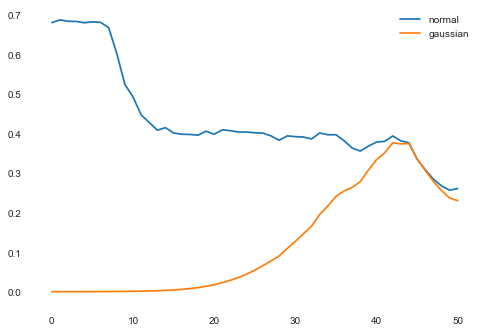

In [13]:
plt.plot(pttest[2,:,2], label='normal')
plt.plot(pptest[2,:,2], label='gaussian')
plt.legend()
plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [53]:
pttest = pttest[:1000]

In [54]:
CONV_filters = 64
LSTM_units_1 = 128
LSTM_units_2 = 64
DENSE_1 = 64
DENSE_2 = 32
ENCODING = 20
DROPOUT_RATE = 0.2

original_dim = pttest.shape[1:]
batch_size = 256

In [55]:
from source.hypermodels import *
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, Bidirectional, LSTM
from tensorflow.keras import backend as K
K.clear_session()

In [56]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [57]:
class MMDiscrepancyLayer(Layer):

    """ Identity transform layer that adds MM discrepancy
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(MMDiscrepancyLayer, self).__init__(*args, **kwargs)

    def call(self, z):
        
        true_samples = K.random_normal(K.shape(z), mean=0., stddev=2./K.cast_to_floatx(K.shape(z)[1]))        
        mmd_batch = compute_mmd(z, true_samples)
        
        self.add_loss(K.mean(mmd_batch), inputs=z)

        return z

In [58]:
# Encoder Layers
Model_E0 = tf.keras.layers.Conv1D(
    filters=CONV_filters,
    kernel_size=5,
    strides=1,
    padding="causal",
    activation="relu",
)
Model_E1 = Bidirectional(
    LSTM(
        LSTM_units_1,
        activation="tanh",
        return_sequences=True,
        kernel_constraint=UnitNorm(axis=0),
    )
)
Model_E2 = Bidirectional(
    LSTM(
        LSTM_units_2,
        activation="tanh",
        return_sequences=False,
        kernel_constraint=UnitNorm(axis=0),
    )
)
Model_E3 = Dense(DENSE_1, activation="relu", kernel_constraint=UnitNorm(axis=0))
Model_E4 = Dense(DENSE_2, activation="relu", kernel_constraint=UnitNorm(axis=0))
Model_E5 = Dense(
            ENCODING,
            activation="relu",
            kernel_constraint=UnitNorm(axis=1),
            activity_regularizer=UncorrelatedFeaturesConstraint(3, weightage=1.0),
        )

# Decoder layers
Model_D4 = Bidirectional(
    LSTM(
        LSTM_units_1,
        activation="tanh",
        return_sequences=True,
        kernel_constraint=UnitNorm(axis=1),
    )
)
Model_D5 = Bidirectional(
    LSTM(
        LSTM_units_1,
        activation="sigmoid",
        return_sequences=True,
        kernel_constraint=UnitNorm(axis=1),
    )
)

# Define and instanciate encoder
x = Input(shape=original_dim)
encoder = Model_E0(x)
encoder = Model_E1(encoder)
encoder = Model_E2(encoder)
encoder = Model_E3(encoder)
encoder = Dropout(DROPOUT_RATE)(encoder)
encoder = Model_E4(encoder)
encoder = Model_E5(encoder)
z_mean = Dense(ENCODING)(encoder)
z_log_sigma = Dense(ENCODING)(encoder)

In [59]:
def sampling(args, epsilon_std=1.):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=K.shape(z_mean),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`

z_mean, z_log_sigma = KLDivergenceLayer()([z_mean, z_log_sigma])
z = Lambda(sampling)([z_mean, z_log_sigma])
z = MMDiscrepancyLayer()(z)

In [60]:
# Define and instanciate decoder
decoder = DenseTranspose(Model_E5, activation="relu", output_dim=ENCODING)(z)
decoder = DenseTranspose(Model_E4, activation="relu", output_dim=DENSE_2)(decoder)
decoder = DenseTranspose(Model_E3, activation="relu", output_dim=DENSE_1)(decoder)
decoder = RepeatVector(pttest.shape[1])(decoder)
decoder = Model_D4(decoder)
decoder = Model_D5(decoder)
x_decoded_mean = TimeDistributed(Dense(original_dim[1]))(decoder)

In [61]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(ENCODING,))
decoder = DenseTranspose(Model_E5, activation="relu", output_dim=ENCODING)(decoder_input)
decoder = DenseTranspose(Model_E4, activation="relu", output_dim=DENSE_2)(decoder)
decoder = DenseTranspose(Model_E3, activation="relu", output_dim=DENSE_1)(decoder)
decoder = RepeatVector(pttest.shape[1])(decoder)
decoder = Model_D4(decoder)
decoder = Model_D5(decoder)
x_decoded_mean = TimeDistributed(Dense(original_dim[1]))(decoder)
generator = Model(decoder_input, x_decoded_mean)

In [62]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 51, 28)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 51, 64)       9024        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 51, 256)      197632      conv1d[0][0]                     
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          164352      bidirectional[0][0]              
______________________________________________________________________________________________

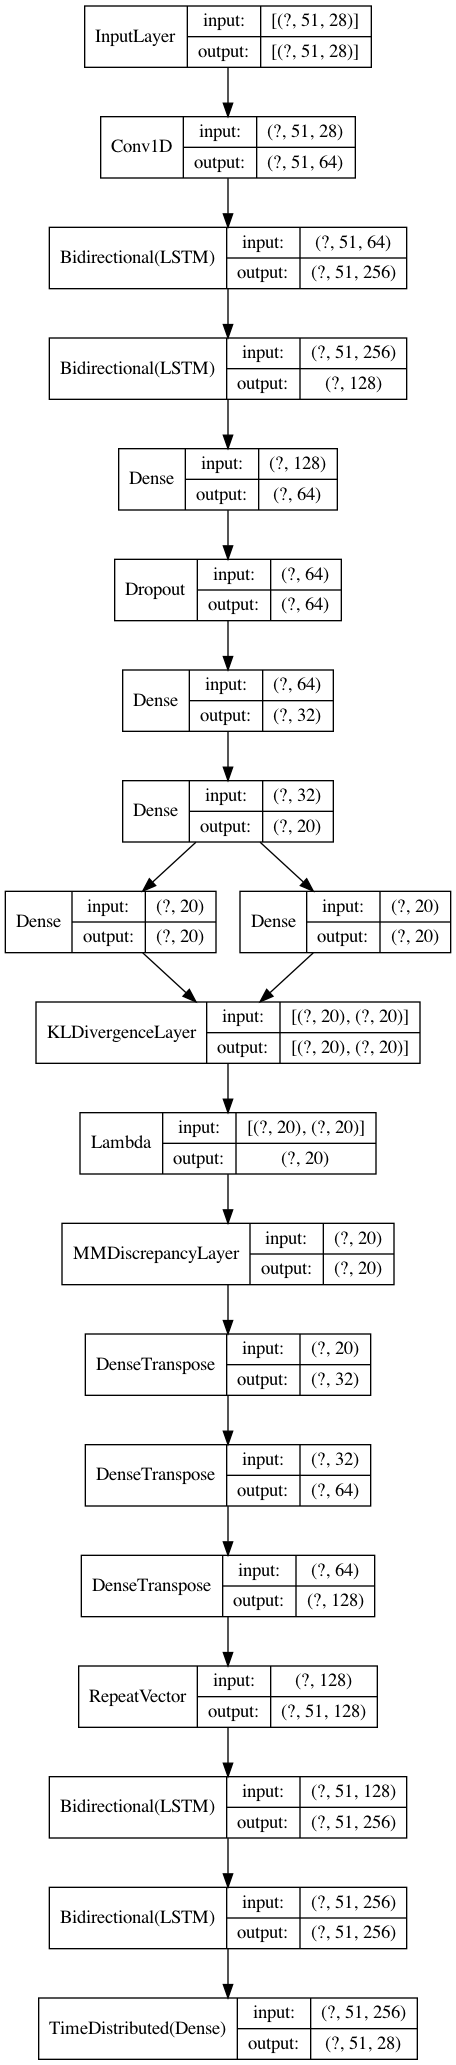

In [64]:
tf.keras.utils.plot_model(vae, show_shapes=True, show_layer_names=False)

In [65]:
def compute_kernel(x, y):
    x_size = K.shape(x)[0]
    y_size = K.shape(y)[0]
    dim = K.shape(x)[1]
    tiled_x = K.tile(K.reshape(x, K.stack([x_size, 1, dim])), K.stack([1, y_size, 1]))
    tiled_y = K.tile(K.reshape(y, K.stack([1, y_size, dim])), K.stack([x_size, 1, 1]))
    return K.exp(-tf.reduce_mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [66]:
from tensorflow.keras.losses import Huber

def huber_loss(x, x_decoded_mean):
    huber_loss = Huber(reduction="sum", delta=100.0)
    return original_dim * huber_loss(x, x_decoded_mean)

vae.compile(optimizer='adam', loss=huber_loss, experimental_run_tf_function=False, metrics=['mae'])

In [73]:
#tf.config.experimental_run_functions_eagerly(False)
ptrain = pttest[np.random.choice(pttest.shape[0], 1000, replace=False), :, :]
history = vae.fit(ptrain, ptrain, epochs=50, batch_size=batch_size, verbose=1)

Train on 1000 samples
Epoch 1/50
1000/1000 [==============================] - ETA: 2s - loss: 910172.5000 - mae: 0.22 - ETA: 1s - loss: 985147.1875 - mae: 0.23 - ETA: 0s - loss: 960010.5208 - mae: 0.22 - 4s 4ms/sample - loss: 958445.4005 - mae: 0.2317
Epoch 2/50
1000/1000 [==============================] - ETA: 3s - loss: 906234.9375 - mae: 0.22 - ETA: 2s - loss: 1048092.7188 - mae: 0.238 - ETA: 0s - loss: 1001497.7083 - mae: 0.233 - 4s 4ms/sample - loss: 982664.5090 - mae: 0.2339
Epoch 3/50
1000/1000 [==============================] - ETA: 2s - loss: 923153.0000 - mae: 0.22 - ETA: 1s - loss: 984390.9375 - mae: 0.23 - ETA: 0s - loss: 1003141.3542 - mae: 0.237 - 4s 4ms/sample - loss: 985050.3325 - mae: 0.2376
Epoch 4/50
1000/1000 [==============================] - ETA: 2s - loss: 1003307.8750 - mae: 0.236 - ETA: 1s - loss: 982379.9688 - mae: 0.236 - ETA: 0s - loss: 958549.8542 - mae: 0.23 - 4s 4ms/sample - loss: 942715.3660 - mae: 0.2323
Epoch 5/50
1000/1000 [===========================

1000/1000 [==============================] - ETA: 3s - loss: 829211.5000 - mae: 0.21 - ETA: 2s - loss: 791376.8438 - mae: 0.20 - ETA: 1s - loss: 779972.5833 - mae: 0.20 - 5s 5ms/sample - loss: 782986.7950 - mae: 0.2108
Epoch 37/50
1000/1000 [==============================] - ETA: 3s - loss: 843483.9375 - mae: 0.21 - ETA: 2s - loss: 810658.0625 - mae: 0.20 - ETA: 1s - loss: 815455.8750 - mae: 0.20 - 5s 5ms/sample - loss: 775352.0070 - mae: 0.2044
Epoch 38/50
1000/1000 [==============================] - ETA: 3s - loss: 671081.1875 - mae: 0.18 - ETA: 6s - loss: 693088.6875 - mae: 0.18 - ETA: 2s - loss: 725650.1250 - mae: 0.19 - 9s 9ms/sample - loss: 728302.2330 - mae: 0.1960
Epoch 39/50
1000/1000 [==============================] - ETA: 3s - loss: 853107.8750 - mae: 0.20 - ETA: 2s - loss: 804364.9375 - mae: 0.20 - ETA: 1s - loss: 800102.1667 - mae: 0.20 - 4s 4ms/sample - loss: 764487.5325 - mae: 0.1996
Epoch 40/50
1000/1000 [==============================] - ETA: 3s - loss: 810931.3750 - m

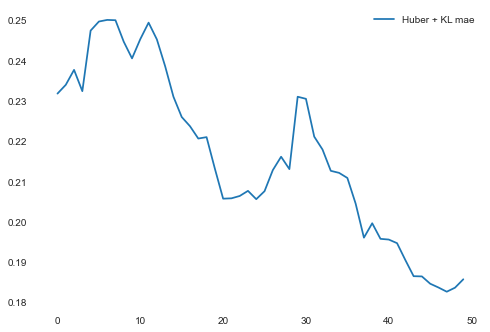

In [74]:
#plt.plot(history.history['mae'], label='Huber + MMD mae')
plt.plot(history.history['mae'], label='Huber + KL mae')

plt.legend()
plt.show()

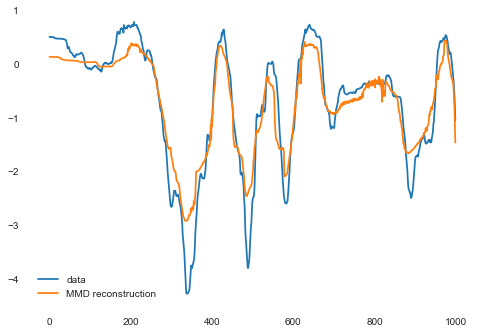

In [76]:
#Huber loss + MMD/ELBO in training data
plt.plot(pttest[:2000,0,0], label='data')
plt.plot(vae.predict(pttest[:2000])[:,0,0], label='MMD reconstruction')

plt.legend()
plt.show()